# Huấn luyện mô hình với SVM (28/03/2025)
Thay đổi chính:
  1. Sử dụng MobileNetV2 để chuẩn hoá thay vì trích xuất thủ công như phiên bản 26.03.2025.
  2. Điều chỉnh gamma từ ***scale*** -> ***auto*** để tăng độ chính xác của mô hình.

Kết quả:
  - Mô hình SVM gốc đạt độ chính xác 99%.
  - Mô hình xấp xỉ TFLite nhận diện chính xác cao.
  - Tập huấn luyện và kiểm tra của Orange còn quá thấp, trong khi Banana quá cáo (tỉ lệ nhận diện Banana là 100%).
  - Tập TF Lite được xấp xỉ đã trở thành mô hình "Mô hình NN Fully Connected" (Không phải SVM hay CNN)

----------------------------------------
Một số lưu ý:
  1. Sử dụng MobileNetV2 thay cách thủ công: Không làm mất tính chất của SVM, mà cải thiện hiệu suất (từ 65% lên 99%) nhờ đặc trưng mạnh mẽ hơn.
  2. Mô hình sau khi train với hàm SVM: Vẫn là SVM, hoạt động trên đặc trưng từ MobileNetV2.
  3. Tệp TF Lite: Không còn là SVM, mà là một mạng nơ-ron fully connected, nhưng không phải CNN.

Liên kết đến Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Thư viện cần thiết

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from imblearn.over_sampling import SMOTE

Generator cho dữ liệu

In [104]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing'

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1059 images belonging to 3 classes.
Found 1117 images belonging to 3 classes.


Tạo mô hình MobileNetV2 để trích xuất đặc trưng

In [4]:
mobilenet_base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
x = mobilenet_base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=mobilenet_base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Hàm trích xuất đặc trưng

In [5]:
def extract_features(generator, feature_extractor):
    features = []
    labels = []
    for i in range(len(generator)):
        images, lbls = next(generator)
        feats = feature_extractor.predict(images)
        features.extend(feats)
        labels.extend(np.argmax(lbls, axis=1))
    return np.array(features), np.array(labels)

Trích xuất đặc trưng

In [6]:
train_features, train_labels = extract_features(train_generator, feature_extractor)
test_features, test_labels = extract_features(test_generator, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

Smote dữ liệu để tăng số lượng mẫu của các lớp ít

In [29]:
smote = SMOTE(random_state=42)
train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)

Huấn luyện mô hình SVM với kernel RBF

In [78]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', class_weight='balanced')     # Chỉnh Gamma từ 'scale' thành 'auto'
svm_model.fit(train_features_resampled, train_labels_resampled)

SVC(class_weight='balanced', gamma='auto')

Đánh giá mô hình

In [79]:
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.5f} %")

Test Accuracy: 99.37332 %




---



In [80]:
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Lưu mô hình dưới dạng .pkl

In [81]:
svm_model_path = '/content/drive/MyDrive/Colab Notebooks/SVM Training/SVM_FruitsClassifi_27032025.pkl'
joblib.dump(svm_model, svm_model_path)
print(f"Đã lưu mô hình SVM tại: {svm_model_path}")

Đã lưu mô hình SVM tại: /content/drive/MyDrive/Colab Notebooks/SVM Training/SVM_FruitsClassifi_27032025.pkl


Chuẩn hoá dữ liệu để huấn luyện mạng Nơron (Xấp xỉ mô hình SVM)

In [82]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Lưu Scaler
scaler_path = '/content/drive/MyDrive/Colab Notebooks/SVM Training/scaler_FruitsClassifi_27032025.pkl'
joblib.dump(scaler, scaler_path)

['/content/drive/MyDrive/Colab Notebooks/SVM Training/scaler_FruitsClassifi_27032025.pkl']

Chuyển nhãn thành One-Hot Encoding

In [89]:
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=3)

Tạo mô hình Nơron để xấp xỉ SVM

In [90]:
tf_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_features_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

Biên dịch mô hình

In [91]:
tf_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Huấn luyện mô hình

In [92]:
tf_model.fit(
    train_features_scaled,
    train_labels_one_hot,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8553 - loss: 0.3297 - val_accuracy: 0.9057 - val_loss: 0.4185
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3921e-06 - val_accuracy: 0.9057 - val_loss: 0.4548
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1558e-06 - val_accuracy: 0.9057 - val_loss: 0.4586
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8697e-06 - val_accuracy: 0.9057 - val_loss: 0.4598
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 3.5119e-06 - val_accuracy: 0.9057 - val_loss: 0.4604
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2014e-06 - val_accuracy: 0.9057 - val_loss: 0.4620
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7720e-06 - val_accuracy: 0.9057 - val_loss: 0.4634
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6586e-06 - val

Lưu mô hình với dạng .h5 và .tflite

In [ ]:
# .h5
tf_model.save('/content/drive/MyDrive/Colab Notebooks/SVM Training/SVM_Approximation_27032025.h5')

# Chuyển đổi sang .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
tflite_model = converter.convert()
tflite_model_path = '/content/drive/MyDrive/Colab Notebooks/SVM Training/SVM_Approximation_27032025.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


Tải tệp .pkl và .tflite về máy tính

In [94]:
from google.colab import files
files.download(svm_model_path)
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hàm dự đoán nhãn của một ảnh từ đường dẫn

In [95]:
def extract_features_from_image(image_path, feature_extractor):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    features = feature_extractor.predict(img_array)
    return features

Dự đoán một ảnh

In [102]:
# Đường dẫn đến ảnh trên Google Drive
# image_path = '/content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Apple/image_22.jpg'
image_path = '/content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Banana/image_49.jpg'
# image_path = '/content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Orange/image_22.jpg'

# Tải scaler
scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/SVM Training/scaler_FruitsClassifi_27032025.pkl')

# Trích xuất đặc trưng từ ảnh
features = extract_features_from_image(image_path, feature_extractor)

# Chuẩn hóa đặc trưng
features_scaled = scaler.transform(features)

# Dự đoán với TF Model xấp xỉ từ SVM
predictions = tf_model.predict(features_scaled)
prediction = np.argmax(predictions[0])

class_labels = list(test_generator.class_indices.keys())
print("Class labels (theo thứ tự mô hình):", class_labels)

predicted_class_tf = class_labels[prediction]

print(f"Ảnh: {image_path}")
print(f"Dự đoán: {predicted_class_tf}")
print(f"Xác suất cho từng lớp: {predictions[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Class labels (theo thứ tự mô hình): ['Apple Ripe', 'Banana Ripe', 'Orange Ripe']
Ảnh: /content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Banana/image_49.jpg
Dự đoán: Banana Ripe
Xác suất cho từng lớp: [2.5371218e-15 1.0000000e+00 6.3776706e-10]


Thử nghiệm với SVM Model (Phiên bản chưa xấp xỉ)

In [103]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Apple/image_22.jpg'
# image_path = '/content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Banana/image_49.jpg'
# image_path = '/content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Orange/image_22.jpg'

svm_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/SVM Training/SVM_FruitsClassifi_27032025.pkl')

class_labels = list(test_generator.class_indices.keys())
print("Class labels (theo thứ tự mô hình):", class_labels)

features = extract_features_from_image(image_path, feature_extractor)
features_scaled = scaler.transform(features)

prediction = svm_model.predict(features_scaled)[0]
predicted_class = class_labels[prediction]

print(f"Ảnh: {image_path}")
print(f"Dự đoán: {predicted_class}")
print(f"Dự đoán (nhãn số): {prediction}")
# Since SVM doesn't directly provide probabilities, we're printing the predicted label instead.

Class labels (theo thứ tự mô hình): ['Apple Ripe', 'Banana Ripe', 'Orange Ripe']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Ảnh: /content/drive/MyDrive/Colab Notebooks/Raspberry Picture/Orange/image_22.jpg
Dự đoán: Orange Ripe
Dự đoán (nhãn số): 2


Tạo biểu đồ đánh giá

Tên các lớp: ['Apple Ripe', 'Banana Ripe', 'Orange Ripe']


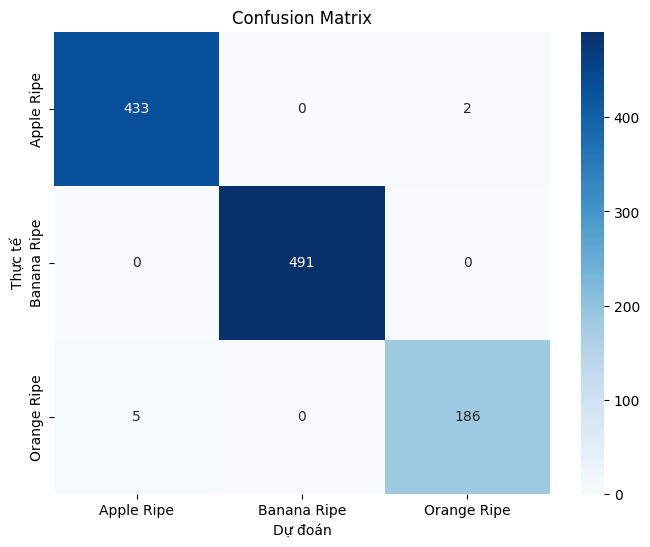

Báo cáo phân loại:
              precision    recall  f1-score   support

  Apple Ripe       0.99      1.00      0.99       435
 Banana Ripe       1.00      1.00      1.00       491
 Orange Ripe       0.99      0.97      0.98       191

    accuracy                           0.99      1117
   macro avg       0.99      0.99      0.99      1117
weighted avg       0.99      0.99      0.99      1117



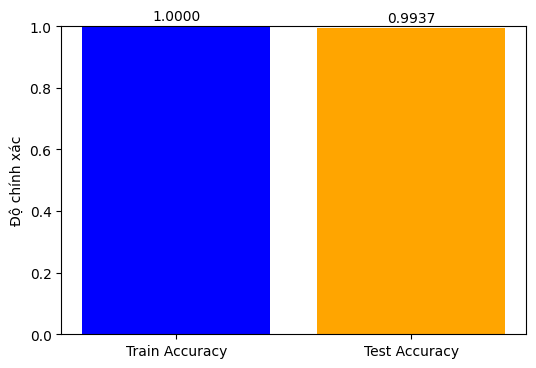

In [101]:
# Tạo confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Lấy danh sách các nhãn duy nhất từ dữ liệu
class_labels = list(train_generator.class_indices.keys())
print("Tên các lớp:", class_labels)

# Vẽ biểu đồ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# In báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(test_labels, test_predictions, target_names=class_labels))

# Vẽ biểu đồ độ chính xác trên tập huấn luyện và kiểm tra
train_predictions = svm_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)

accuracies = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']

plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Độ chính xác')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.show()

In [105]:
import os
from pathlib import Path

test_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Testing'

# Định nghĩa các định dạng ảnh hợp lệ
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# Đếm số lượng ảnh trong test_dir và các thư mục con
total_images = 0
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(valid_extensions):
            total_images += 1
    print(f"Thư mục: {root}, Số lượng ảnh: {len([f for f in files if f.lower().endswith(valid_extensions)])}")

print(f"Tổng số ảnh trong test_dir: {total_images}")

Thư mục: /content/drive/MyDrive/Colab Notebooks/Dataset/Testing, Số lượng ảnh: 0
Thư mục: /content/drive/MyDrive/Colab Notebooks/Dataset/Testing/Orange Ripe, Số lượng ảnh: 191
Thư mục: /content/drive/MyDrive/Colab Notebooks/Dataset/Testing/Apple Ripe, Số lượng ảnh: 435
Thư mục: /content/drive/MyDrive/Colab Notebooks/Dataset/Testing/Banana Ripe, Số lượng ảnh: 491
Tổng số ảnh trong test_dir: 1117
